In [1]:
import numpy as np
import pandas as pd
from synthlearners import PenguinSynth

In [2]:
# Create simple synthetic panel data
np.random.seed(42)

# Panel structure
n_units = 20
n_treated = 5
n_time = 15
t_treatment = 10

# Generate unit and time effects
unit_effects = np.random.normal(0, 1, n_units)
time_effects = np.random.normal(0, 0.5, n_time)

# Treatment effect
treatment_effect = 2.0

# Generate outcomes
Y = np.zeros((n_units, n_time))
for i in range(n_units):
    for t in range(n_time):
        Y[i, t] = unit_effects[i] + time_effects[t] + np.random.normal(0, 0.2)

        # Add treatment effect for treated units after treatment
        if i >= (n_units - n_treated) and t >= t_treatment:
            Y[i, t] += treatment_effect

# Convert to long format dataframe
data = []
for i in range(n_units):
    for t in range(n_time):
        is_treated = i >= (n_units - n_treated)
        is_post = t >= t_treatment
        treat_indicator = 1 if (is_treated and is_post) else 0

        data.append({
            'unit': i,
            'time': t,
            'treat': treat_indicator,
            'outcome': Y[i, t]
        })

df = pd.DataFrame(data)
df.head()

,unit,time,treat,outcome
0,0,0,0,0.985370
1,0,1,0,0.425599
2,0,2,0,0.138544
3,0,3,0,-0.481297
4,0,4,0,0.263895


In [3]:
print(f"Panel data: {n_units} units, {n_time} time periods")
print(f"Treatment: {n_treated} units treated at period {t_treatment}")
print(f"True treatment effect: {treatment_effect}")

Panel data: 20 units, 15 time periods
Treatment: 5 units treated at period 10
True treatment effect: 2.0


In [4]:
# Test different methods and regularization levels
configs = [
    {"method": "synth", "l1_ratio": 0.0, "name": "Ridge Synth"},
    {"method": "synth", "l1_ratio": 0.5, "name": "ElasticNet Synth"},
    {"method": "synth", "l1_ratio": 1.0, "name": "Lasso Synth"},
    {"method": "sdid", "l1_ratio": 0.0, "name": "Ridge SDID"},
    {"method": "did", "l1_ratio": 0.0, "name": "DiD"},
]

results = {}

for config in configs:
    print(f"Fitting {config['name']}...")

    estimator = PenguinSynth(
        method=config["method"],
        l1_ratio=config["l1_ratio"],
        intercept=True,
        noisy=False
    )

    try:
        result = estimator.fit(
            df=df,
            unit_id='unit',
            time_id='time',
            treat='treat',
            outcome='outcome'
        )

        results[config["name"]] = result

        print(f"  ATT: {result.att:.3f}")
        print(f"  Pre-treatment RMSE: {result.pre_treatment_rmse:.3f}")
        print(f"  Regularization λ: {result.lambda_reg[0]:.6f}")
        print(f"  Non-zero weights: {np.sum(np.abs(result.weights) > 1e-6)}/{len(result.weights)}")
        print()

    except Exception as e:
        print(f"  Error: {e}")
        print()


Fitting Ridge Synth...
  ATT: 2.001
  Pre-treatment RMSE: 0.078
  Regularization λ: 0.082290
  Non-zero weights: 15/15

Fitting ElasticNet Synth...
  ATT: 2.006
  Pre-treatment RMSE: 0.074
  Regularization λ: 0.016534
  Non-zero weights: 8/15

Fitting Lasso Synth...
  ATT: 2.040
  Pre-treatment RMSE: 0.088
  Regularization λ: 0.016534
  Non-zero weights: 5/15

Fitting Ridge SDID...
  ATT: 1.988
  Pre-treatment RMSE: 0.088
  Regularization λ: 0.131029
  Non-zero weights: 15/15

Fitting DiD...
  ATT: 1.966
  Pre-treatment RMSE: 0.720
  Regularization λ: 0.000000
  Non-zero weights: 15/15



Testing plotting functionality...


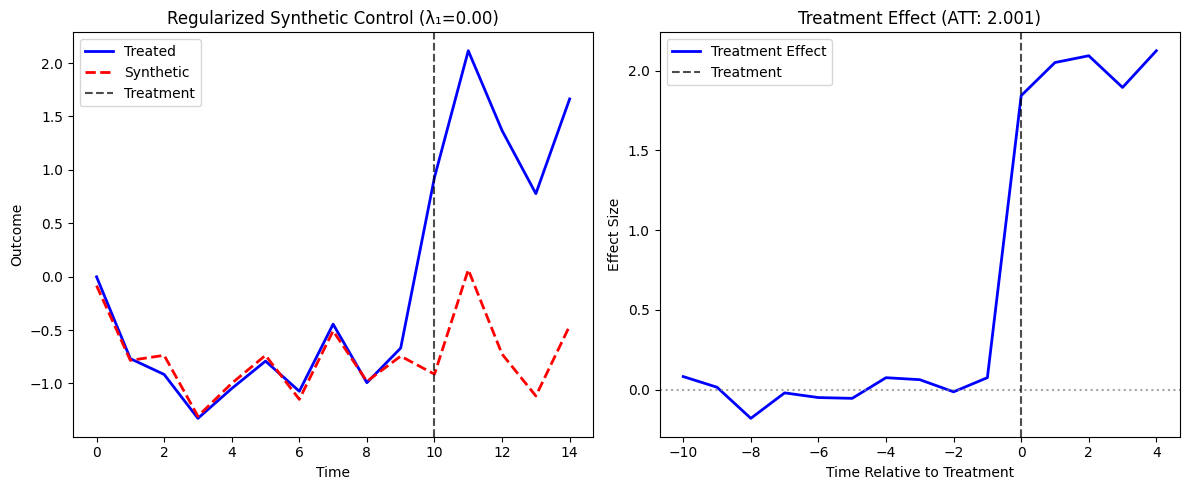

In [5]:
import matplotlib.pyplot as plt
print("Testing plotting functionality...")
# Plot Ridge synthetic control results
if "Ridge Synth" in results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    result = results["Ridge Synth"]
    result.plot(mode="raw", ax=ax1, T_pre=t_treatment)
    result.plot(mode="effect", ax=ax2, T_pre=t_treatment)

    plt.tight_layout()